# BindCraft CSV Aggregation + Evaluation

This notebook collects results from multiple BindCraft CSV files into one large pandas DataFrame, then:

1. Sorts rows by a chosen score column (default: `Average_pLDDT`) and drops rows with missing score.
2. Handles duplicates by `Sequence` in two ways:
   - **List-DF**: one row per unique `Sequence`, each cell holds a list of values across duplicates (missing values become `None`).
   - **Dedup/Averaged DF**: one row per unique `Sequence`, numeric columns are averaged, string columns are taken from the highest-scoring duplicate, then duplicates are removed.
3. Plots `Average_pLDDT` vs user-selected columns for both raw and dedup DataFrames.
4. Runs PCA / t-SNE / UMAP for visualization and colors points by a user-selected column.

Notes:
- BindCraft outputs a wide `repredict_stats.csv` style table with many `Average_*` columns. This notebook is designed for that format but can still merge arbitrary CSVs (missing columns become NaN).
- Some columns like `InterfaceAAs` may be strings representing dicts; this notebook excludes them from numeric embeddings by default.

In [1]:
# ==============================
# Cell 2: User configuration
# ==============================
from pathlib import Path

# Directory containing CSV files to merge
CSV_DIR = Path("example/c5/out_csv")

# Which CSV files to include (glob patterns). You can add more patterns if needed.
CSV_GLOBS = ["**/*.csv"]

# Score column used for sorting and for choosing the best row among duplicates for string fields
SCORE_COL = "Average_pLDDT"

# Columns you want to evaluate / plot against SCORE_COL
EVAL_COLS = [
    "Average_i_pTM",
    "Average_pTM",
    "Average_Relaxed_Clashes",
    "Average_dG/dSASA",
    "Average_ShapeComplementarity",
    "Average_Hotspot_RMSD",
    "Average_InterfaceHbondsPercentage"
]

# Color points by this column in plots/embeddings
COLOR_COL = "Average_i_pTM"

# Duplicate handling key
DUP_KEY = "Sequence"

# Embedding settings
EMBED_ON = "dedup"  # 'dedup' recommended; alternatively 'raw'
N_COMPONENTS = 2
RANDOM_STATE = 0

# Optional: manually specify which columns to use as features for PCA/t-SNE/UMAP.
# - Set to None to auto-select numeric Average_* columns.
# - If you set a list, only those columns (that exist + are numeric) will be used.
# EMBED_FEATURE_COLS = None

EMBED_FEATURE_COLS = [
    "Average_pLDDT",
    "Average_i_pTM",
    "Average_pTM",
    "Average_pAE",
    "Average_Relaxed_Clashes",
    "Average_dG/dSASA",
    "Average_ShapeComplementarity",
    "Average_Hotspot_RMSD",
    "Average_Target_RMSD",
    "Average_InterfaceHbondsPercentage",
    "Average_InterfaceUnsatHbondsPercentage"
]

# UMAP is optional (requires 'umap-learn')
RUN_UMAP = True

CSV_DIR

PosixPath('example/c5/out_csv')

In [2]:
# ==============================
# Cell 3: Imports
# ==============================
import math
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# In notebooks, display() is available; provide a safe fallback otherwise.
try:
    from IPython.display import display  # type: ignore
except Exception:
    display = print

# scikit-learn is required for PCA/t-SNE; fail with a clear message if missing.
try:
    from sklearn.impute import SimpleImputer
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE
except Exception as exc:
    raise ImportError("Missing scikit-learn. Install with: pip install scikit-learn") from exc

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 180)

print('pandas', pd.__version__)

pandas 2.2.1


In [3]:
# ==============================
# Cell 4: CSV discovery + loading
# ==============================
from pathlib import Path

def discover_csv_files(csv_dir: Path, globs: list[str]) -> list[Path]:
    csv_dir = Path(csv_dir).expanduser()
    if not csv_dir.exists():
        raise FileNotFoundError(f'CSV_DIR does not exist: {csv_dir}')

    files: list[Path] = []
    for g in globs:
        files.extend(csv_dir.glob(g))

    files = [p for p in files if p.is_file() and p.suffix.lower() == '.csv']
    # Deduplicate while preserving order
    seen = set()
    unique = []
    for p in sorted(files):
        if p in seen:
            continue
        seen.add(p)
        unique.append(p)
    return unique


def read_csv_safely(path: Path) -> pd.DataFrame:
    # Keep default dtype inference, but allow messy CSVs
    try:
        df = pd.read_csv(path)
    except Exception:
        # fallback for rare malformed files
        df = pd.read_csv(path, engine='python')

    df['source_file'] = str(path)
    df['source_name'] = path.name
    return df


def concat_csvs(paths: list[Path]) -> pd.DataFrame:
    if not paths:
        return pd.DataFrame()
    dfs = []
    for p in paths:
        dfs.append(read_csv_safely(p))
    # Union columns; missing columns -> NaN
    return pd.concat(dfs, ignore_index=True, sort=False)


csv_files = discover_csv_files(CSV_DIR, CSV_GLOBS)
print(f'Discovered {len(csv_files)} CSV file(s) under {CSV_DIR}')
for p in csv_files[:10]:
    print(' -', p)
if len(csv_files) > 10:
    print(' ...')

df_raw = concat_csvs(csv_files)
print('Raw merged shape:', df_raw.shape)
df_raw.head(2)

Discovered 5 CSV file(s) under example/c5/out_csv
 - example/c5/out_csv/_work_oo80wopo-bindcraft_BindCraftPeptide_data_c5_binder_sc66_task_2_repredict_stats.csv
 - example/c5/out_csv/_work_oo80wopo-bindcraft_BindCraftPeptide_data_c5_binder_sc66_task_3_repredict_stats.csv
 - example/c5/out_csv/_work_oo80wopo-bindcraft_BindCraftPeptide_data_c5_binder_sc66_task_4_repredict_stats.csv
 - example/c5/out_csv/_work_oo80wopo-bindcraft_BindCraftPeptide_data_c5_binder_sc69_task_3_repredict_stats.csv
 - example/c5/out_csv/_work_oo80wopo-bindcraft_BindCraftPeptide_data_c5_binder_sc69_task_4_repredict_stats.csv
Raw merged shape: (311, 233)


,Design,Protocol,Length,Seed,Helicity,Target_Hotspot,Sequence,InterfaceResidues,MPNN_score,MPNN_seq_recovery,Average_pLDDT,1_pLDDT,2_pLDDT,3_pLDDT,4_pLDDT,5_pLDDT,Average_pTM,1_pTM,2_pTM,3_pTM,4_pTM,5_pTM,Average_i_pTM,1_i_pTM,2_i_pTM,3_i_pTM,4_i_pTM,5_i_pTM,Average_pAE,1_pAE,2_pAE,3_pAE,4_pAE,5_pAE,Average_i_pAE,1_i_pAE,2_i_pAE,3_i_pAE,4_i_pAE,5_i_pAE,Average_i_pLDDT,1_i_pLDDT,2_i_pLDDT,3_i_pLDDT,4_i_pLDDT,5_i_pLDDT,Average_ss_pLDDT,1_ss_pLDDT,2_ss_pLDDT,3_ss_pLDDT,4_ss_pLDDT,5_ss_pLDDT,Average_Unrelaxed_Clashes,1_Unrelaxed_Clashes,2_Unrelaxed_Clashes,3_Unrelaxed_Clashes,4_Unrelaxed_Clashes,5_Unrelaxed_Clashes,Average_Relaxed_Clashes,1_Relaxed_Clashes,2_Relaxed_Clashes,3_Relaxed_Clashes,4_Relaxed_Clashes,5_Relaxed_Clashes,Average_Binder_Energy_Score,1_Binder_Energy_Score,2_Binder_Energy_Score,3_Binder_Energy_Score,4_Binder_Energy_Score,5_Binder_Energy_Score,Average_Surface_Hydrophobicity,1_Surface_Hydrophobicity,2_Surface_Hydrophobicity,3_Surface_Hydrophobicity,4_Surface_Hydrophobicity,5_Surface_Hydrophobicity,Average_ShapeComplementarity,1_ShapeComplementarity,2_ShapeComplementarity,3_ShapeComplementarity,4_ShapeComplementarity,5_ShapeComplementarity,Average_PackStat,1_PackStat,2_PackStat,3_PackStat,4_PackStat,5_PackStat,Average_dG,1_dG,2_dG,3_dG,4_dG,5_dG,Average_dSASA,1_dSASA,2_dSASA,3_dSASA,4_dSASA,5_dSASA,...,3_InterfaceHbondsPercentage,4_InterfaceHbondsPercentage,5_InterfaceHbondsPercentage,Average_n_InterfaceUnsatHbonds,1_n_InterfaceUnsatHbonds,2_n_InterfaceUnsatHbonds,3_n_InterfaceUnsatHbonds,4_n_InterfaceUnsatHbonds,5_n_InterfaceUnsatHbonds,Average_InterfaceUnsatHbondsPercentage,1_InterfaceUnsatHbondsPercentage,2_InterfaceUnsatHbondsPercentage,3_InterfaceUnsatHbondsPercentage,4_InterfaceUnsatHbondsPercentage,5_InterfaceUnsatHbondsPercentage,Average_Interface_Helix%,1_Interface_Helix%,2_Interface_Helix%,3_Interface_Helix%,4_Interface_Helix%,5_Interface_Helix%,Average_Interface_BetaSheet%,1_Interface_BetaSheet%,2_Interface_BetaSheet%,3_Interface_BetaSheet%,4_Interface_BetaSheet%,5_Interface_BetaSheet%,Average_Interface_Loop%,1_Interface_Loop%,2_Interface_Loop%,3_Interface_Loop%,4_Interface_Loop%,5_Interface_Loop%,Average_Binder_Helix%,1_Binder_Helix%,2_Binder_Helix%,3_Binder_Helix%,4_Binder_Helix%,5_Binder_Helix%,Average_Binder_BetaSheet%,1_Binder_BetaSheet%,2_Binder_BetaSheet%,3_Binder_BetaSheet%,4_Binder_BetaSheet%,5_Binder_BetaSheet%,Average_Binder_Loop%,1_Binder_Loop%,2_Binder_Loop%,3_Binder_Loop%,4_Binder_Loop%,5_Binder_Loop%,Average_InterfaceAAs,1_InterfaceAAs,2_InterfaceAAs,3_InterfaceAAs,4_InterfaceAAs,5_InterfaceAAs,Average_Hotspot_RMSD,1_Hotspot_RMSD,2_Hotspot_RMSD,3_Hotspot_RMSD,4_Hotspot_RMSD,5_Hotspot_RMSD,Average_Target_RMSD,1_Target_RMSD,2_Target_RMSD,3_Target_RMSD,4_Target_RMSD,5_Target_RMSD,Average_Binder_pLDDT,1_Binder_pLDDT,2_Binder_pLDDT,3_Binder_pLDDT,4_Binder_pLDDT,5_Binder_pLDDT,Average_Binder_pTM,1_Binder_pTM,2_Binder_pTM,3_Binder_pTM,4_Binder_pTM,5_Binder_pTM,Average_Binder_pAE,1_Binder_pAE,2_Binder_pAE,3_Binder_pAE,4_Binder_pAE,5_Binder_pAE,Average_Binder_RMSD,1_Binder_RMSD,2_Binder_RMSD,3_Binder_RMSD,4_Binder_RMSD,5_Binder_RMSD,DesignTime,Notes,TargetSettings,Filters,AdvancedSettings,source_file,source_name
0,c5_binder_sc66_l13_s588478_mpnn10_model_0,4stage,13,0,-0.3,NaN,CWGPDGWFVPGPC,"B2,B5,B6,B7,B8,B9,B10",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.35,0.35,NaN,NaN,NaN,NaN,0.36,0.36,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,-25.32,-25.32,NaN,NaN,NaN,NaN,0.92,0.92,NaN,NaN,NaN,NaN,0.75,0.75,NaN,NaN,NaN,NaN,0.67,0.67,NaN,NaN,NaN,NaN,-21.86,-21.86,NaN,NaN,NaN,NaN,832.78,832.78,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,28.57,28.57,NaN,NaN,NaN,NaN,71.43,71.43,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,15.38,15.38,NaN,NaN,NaN,NaN,84.62,84.62,NaN,NaN,NaN,NaN,"{'A': 0.0, 'C': 0.0, 'D': 1.0, 'E': 0.0, 'F': ...","{'A': 0, 'C': 0, 'D': 1,

In [4]:
# ==============================
# Cell 5: Coerce numeric columns + sanity checks
# ==============================
def coerce_numeric_columns(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    # Convert BindCraft-like metric columns to numeric when possible
    numeric_like = []
    for c in out.columns:
        if c.startswith('Average_') or re.match(r'^[1-5]_.*', c):
            numeric_like.append(c)
    # Also common numeric fields
    for c in ['Length', 'Seed', 'Helicity', 'MPNN_score', 'MPNN_seq_recovery']:
        if c in out.columns:
            numeric_like.append(c)

    numeric_like = sorted(set(numeric_like))
    for c in numeric_like:
        out[c] = pd.to_numeric(out[c], errors='coerce')

    return out


# Ensure re is available in this cell scope
import re

df = coerce_numeric_columns(df_raw)
missing = [c for c in [SCORE_COL, DUP_KEY] if c not in df.columns]
if missing:
    raise KeyError(f'Missing required column(s) in merged df: {missing}. Available columns: {list(df.columns)[:50]} ...')

print('Columns:', len(df.columns))
print('Example columns:', list(df.columns)[:25])
df[[DUP_KEY, SCORE_COL, 'source_name']].head(10)

Columns: 233
Example columns: ['Design', 'Protocol', 'Length', 'Seed', 'Helicity', 'Target_Hotspot', 'Sequence', 'InterfaceResidues', 'MPNN_score', 'MPNN_seq_recovery', 'Average_pLDDT', '1_pLDDT', '2_pLDDT', '3_pLDDT', '4_pLDDT', '5_pLDDT', 'Average_pTM', '1_pTM', '2_pTM', '3_pTM', '4_pTM', '5_pTM', 'Average_i_pTM', '1_i_pTM', '2_i_pTM']


,Sequence,Average_pLDDT,source_name
0,CWGPDGWFVPGPC,NaN,_work_oo80wopo-bindcraft_BindCraftPeptide_data...
1,CWGSDGWFVPGPC,NaN,_work_oo80wopo-bindcraft_BindCraftPeptide_data...
2,CWAPDGWFVPGPC,NaN,_work_oo80wopo-bindcraft_BindCraftPeptide_data...
3,CWGSDGWFVPGPC,NaN,_work_oo80wopo-bindcraft_BindCraftPeptide_data...
4,CWGSDGWFIPGSC,NaN,_work_oo80wopo-bindcraft_BindCraftPeptide_data...
5,CWGSDGWFIPGSC,NaN,_work_oo80wopo-bindcraft_BindCraftPeptide_data...
6,CFGSDGWFIPGSC,NaN,_work_oo80wopo-bindcraft_BindCraftPeptide_data...
7,CWGSDGWFIPGPC,NaN,_work_oo80wopo-bindcraft_BindCraftPeptide_data...
8,CWGSDGWFVPGSC,NaN,_work_oo80wopo-bindcraft_BindCraftPeptide_data...
9,CWAPDGWFVPGPC,NaN,_work_oo80wopo-bindcraft_BindCraftPeptide_data...


In [5]:
# ==============================
# Cell 6: Task 1 — drop missing score + sort descending
# ==============================
df_scored = df.copy()
df_scored = df_scored[df_scored[SCORE_COL].notna()].copy()
df_scored.sort_values(by=[SCORE_COL], ascending=False, inplace=True)
df_scored.reset_index(drop=True, inplace=True)

print('After dropping missing score + sorting:')
print('Shape:', df_scored.shape)
df_scored[[DUP_KEY, SCORE_COL, 'source_name']].head(10)

After dropping missing score + sorting:
Shape: (85, 233)


,Sequence,Average_pLDDT,source_name
0,CDYVLGDDGKWVC,0.81,_work_oo80wopo-bindcraft_BindCraftPeptide_data...
1,CDWVLGSDSKWVC,0.81,_work_oo80wopo-bindcraft_BindCraftPeptide_data...
2,CDYVYGPDSQWKC,0.80,_work_oo80wopo-bindcraft_BindCraftPeptide_data...
3,CFETEWLKIC,0.80,_work_oo80wopo-bindcraft_BindCraftPeptide_data...
4,CDWVYGSDSRWVC,0.80,_work_oo80wopo-bindcraft_BindCraftPeptide_data...
5,CFETEWLKIC,0.80,_work_oo80wopo-bindcraft_BindCraftPeptide_data...
6,CFETDWLKIC,0.79,_work_oo80wopo-bindcraft_BindCraftPeptide_data...
7,CFKTEWLEIC,0.79,_work_oo80wopo-bindcraft_BindCraftPeptide_data...
8,CLQTDWLTIC,0.79,_work_oo80wopo-bindcraft_BindCraftPeptide_data...
9,CFETEWLKIC,0.79,_work_oo80wopo-bindcraft_BindCraftPeptide_data...


In [7]:
# ==============================
# Cell 7: Task 2 — duplicates by Sequence
#   (A) df_list: list values per duplicate
#   (B) df_dedup: numeric mean, strings from best-scoring row
# ==============================
def _value_to_jsonable(x):
    # Convert NaN to None for nicer list-cells
    if x is None:
        return None
    try:
        if isinstance(x, float) and math.isnan(x):
            return None
    except Exception:
        pass
    return x


def make_list_df(df_in: pd.DataFrame, key: str) -> pd.DataFrame:
    # Ensure stable order: df_in is assumed pre-sorted (best first)
    grouped = df_in.groupby(key, dropna=False, sort=False)

    def agg_series(s: pd.Series):
        return [_value_to_jsonable(v) for v in s.tolist()]

    df_list = grouped.agg(agg_series)
    df_list['n_duplicates'] = grouped.size().astype(int)
    df_list = df_list.reset_index()
    return df_list


def make_dedup_df(df_in: pd.DataFrame, key: str, score_col: str) -> pd.DataFrame:
    # df_in is assumed sorted descending by score_col
    numeric_cols = [c for c in df_in.columns if pd.api.types.is_numeric_dtype(df_in[c])]
    # Keep the score_col in numeric_cols even if loaded as object
    if score_col not in numeric_cols and score_col in df_in.columns:
        numeric_cols.append(score_col)

    # Exclude group key from numeric mean; it will be re-added
    numeric_cols = [c for c in numeric_cols if c != key]

    # For non-numeric (string/object) columns: take from best row (already first)
    non_numeric_cols = [c for c in df_in.columns if c not in numeric_cols and c != key]

    grouped = df_in.groupby(key, dropna=False, sort=False)

    # Mean for numeric (ignores NaN by default)
    df_num = grouped[numeric_cols].mean(numeric_only=True) if numeric_cols else pd.DataFrame(index=grouped.size().index)

    # Best row for strings: pick first row per group (df_in sorted => highest score)
    df_best = grouped[non_numeric_cols].first() if non_numeric_cols else pd.DataFrame(index=grouped.size().index)

    out = pd.concat([df_num, df_best], axis=1)
    out['n_duplicates'] = grouped.size().astype(int)
    out = out.reset_index()

    # Re-sort by the mean score if present
    if score_col in out.columns:
        out = out.sort_values(by=[score_col], ascending=False).reset_index(drop=True)
    return out


df_list = make_list_df(df_scored, DUP_KEY)
df_dedup = make_dedup_df(df_scored, DUP_KEY, SCORE_COL)

print('df_list shape:', df_list.shape)
print('df_dedup shape:', df_dedup.shape)

print('Top duplicates by count:')
display(df_dedup[['n_duplicates', DUP_KEY, SCORE_COL]].head(10))

# Show one example of list-cells for the top sequence
example_seq = df_dedup.loc[0, DUP_KEY]
row_list = df_list[df_list[DUP_KEY] == example_seq].iloc[0]
print('Example Sequence:', example_seq)
print('List of scores for this Sequence:', row_list[SCORE_COL])
row_list[[DUP_KEY, 'n_duplicates', SCORE_COL, 'Design', 'source_name']] if 'Design' in df_list.columns else row_list[[DUP_KEY, 'n_duplicates', SCORE_COL, 'source_name']]

df_list shape: (67, 234)
df_dedup shape: (67, 234)
Top duplicates by count:


/tmp/ipykernel_495695/1976882087.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_list['n_duplicates'] = grouped.size().astype(int)


,n_duplicates,Sequence,Average_pLDDT
0,1,CDYVLGDDGKWVC,0.810000
1,1,CDWVLGSDSKWVC,0.810000
2,1,CDYVYGPDSQWKC,0.800000
3,1,CDWVYGSDSRWVC,0.800000
4,1,CLQTEWLTIC,0.790000
5,1,CDWVWTADNRWKC,0.790000
6,1,CLQTDWLTIC,0.790000
7,1,CFKTEWLEIC,0.790000
8,4,CFETEWLKIC,0.787500
9,3,CFETDWLKIC,0.783333


Example Sequence: CDYVLGDDGKWVC
List of scores for this Sequence: [0.81]


Sequence                                             CDYVLGDDGKWVC
n_duplicates                                                     1
Average_pLDDT                                               [0.81]
Design                          [c5_binder_sc69_l13_s17575_mpnn16]
source_name      [_work_oo80wopo-bindcraft_BindCraftPeptide_dat...
Name: 0, dtype: object

Plotting raw (with duplicates)


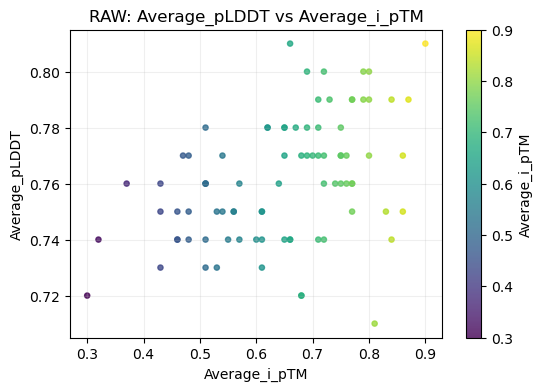

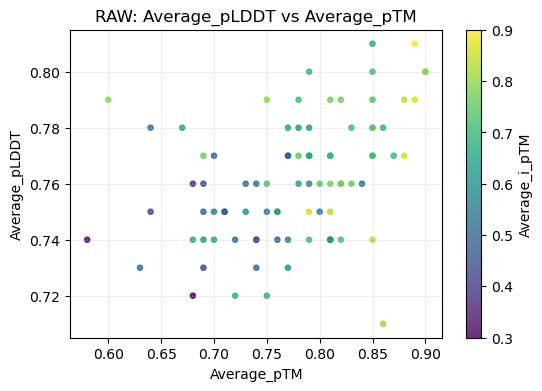

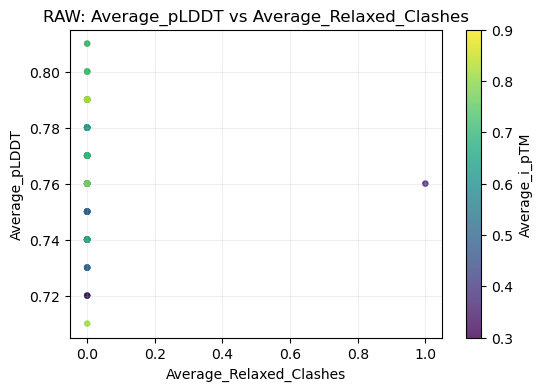

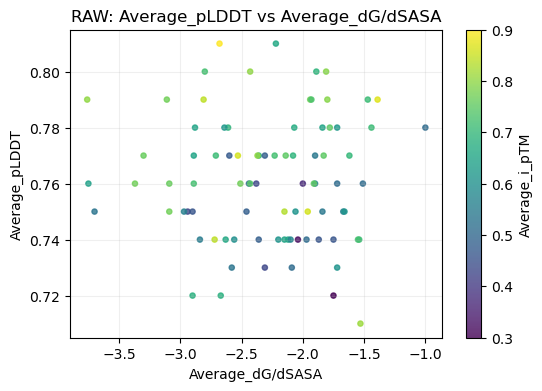

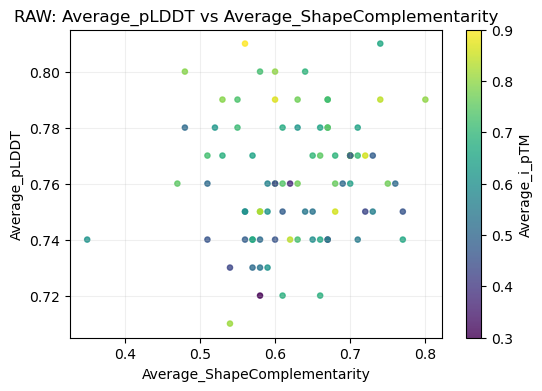

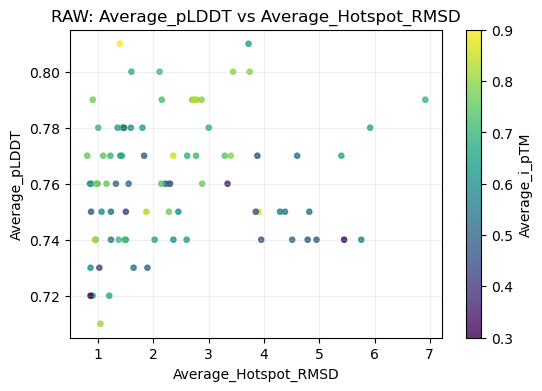

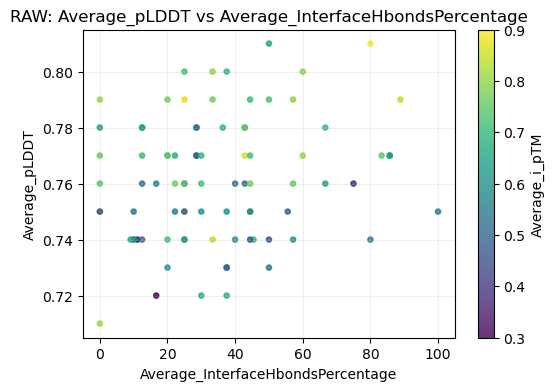

Plotting dedup (averaged per Sequence)


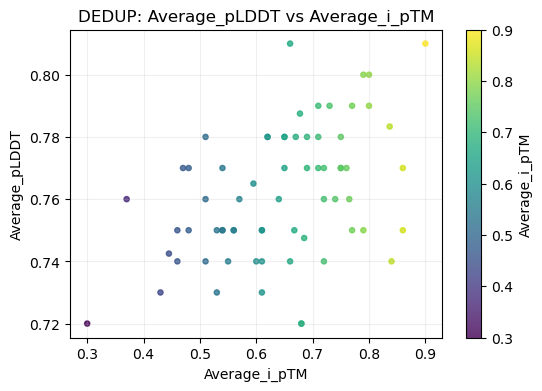

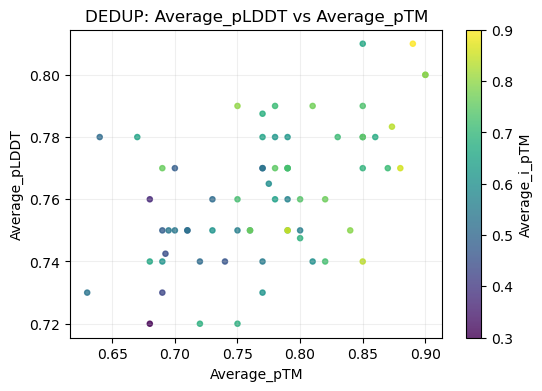

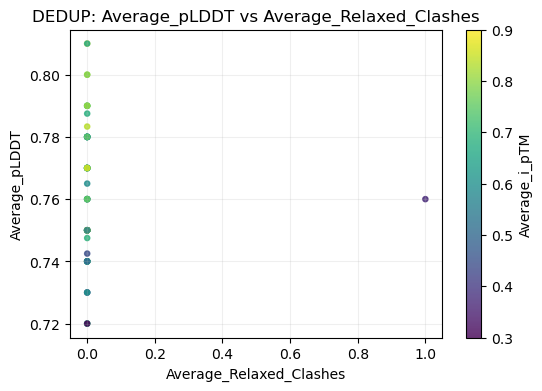

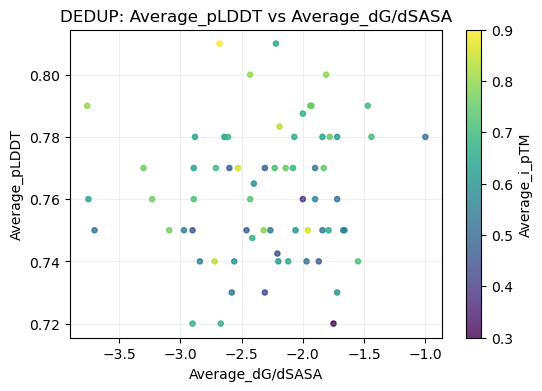

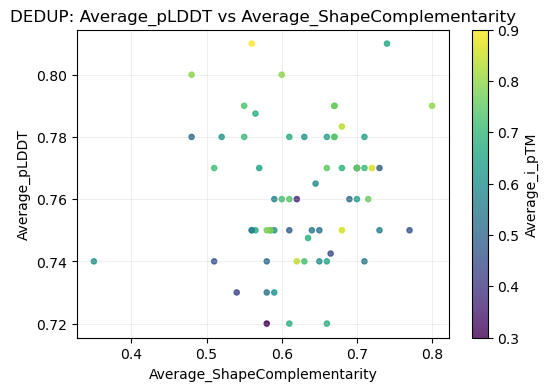

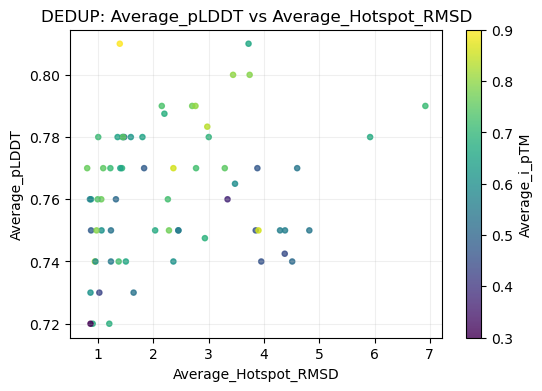

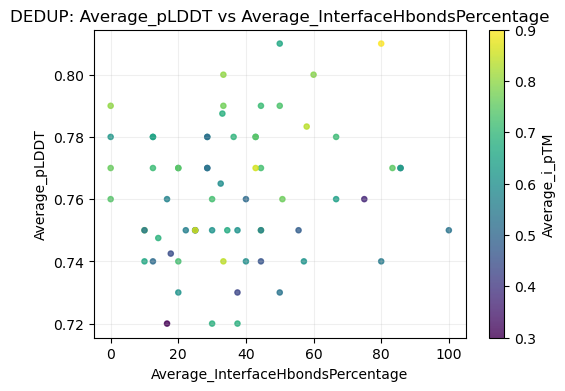

In [8]:
# ==============================
# Cell 8: Task 3 — plots (raw vs dedup)
# ==============================
def scatter_score_vs(df_in: pd.DataFrame, x_col: str, score_col: str, color_col: str | None = None, title: str | None = None):
    # Drop rows missing x or score
    d = df_in.copy()
    if score_col in d.columns:
        d = d[d[score_col].notna()]
    if x_col in d.columns:
        d = d[d[x_col].notna()]

    if d.empty:
        print(f'No data to plot for {x_col}')
        return

    plt.figure(figsize=(6, 4))
    if color_col and color_col in d.columns and pd.api.types.is_numeric_dtype(d[color_col]):
        sc = plt.scatter(d[x_col], d[score_col], c=d[color_col], s=14, cmap='viridis', alpha=0.8)
        plt.colorbar(sc, label=color_col)
    else:
        plt.scatter(d[x_col], d[score_col], s=14, alpha=0.8)

    plt.xlabel(x_col)
    plt.ylabel(score_col)
    plt.title(title or f'{score_col} vs {x_col}')
    plt.grid(True, alpha=0.2)
    plt.show()


print('Plotting raw (with duplicates)')
for col in EVAL_COLS:
    if col in df_scored.columns:
        scatter_score_vs(df_scored, col, SCORE_COL, COLOR_COL, title=f'RAW: {SCORE_COL} vs {col}')
    else:
        print('Missing col in raw df:', col)

print('Plotting dedup (averaged per Sequence)')
for col in EVAL_COLS:
    if col in df_dedup.columns:
        scatter_score_vs(df_dedup, col, SCORE_COL, COLOR_COL, title=f'DEDUP: {SCORE_COL} vs {col}')
    else:
        print('Missing col in dedup df:', col)

## Task 4 — PCA / t-SNE / UMAP: `raw` vs `dedup` (and what information is lost)

You control this with `EMBED_ON` in Cell 2:

- `EMBED_ON = 'dedup'` (**recommended**)
  - Embeds **one point per unique `Sequence`** using the **averaged** row in `df_dedup`.
  - Prevents plots being dominated by reruns / repeated scoring of the same peptide.
  - Keeps `n_duplicates`, so you still know how many times a sequence appeared (you can later size points by it if desired).

- `EMBED_ON = 'raw'`
  - Embeds **every row** in the original merged dataframe (after sorting / filtering by score).
  - Preserves per-run variation, but duplicate sequences will overlap and visually overweight repeated entries.
  - Useful if you explicitly want to see run-to-run / model-to-model variability.

### Which one should you use?
- For exploring **sequence space**, cluster structure, and selecting diverse top hits: use **`dedup`**.
- For diagnosing pipeline noise / repeated scoring stability: use **`raw`**.

### Feature columns for embeddings
By default, the notebook auto-selects numeric `Average_*` columns (good for BindCraft’s wide tables).
If you want full control, set `EMBED_FEATURE_COLS` in Cell 2 to an explicit list of columns (e.g., `['Average_pLDDT','Average_i_pTM',...]`).
The embedding cell will ignore missing/non-numeric columns and print what it actually used.

Embedding on: DEDUP | rows=67 | features=11
Feature columns used: ['Average_pLDDT', 'Average_i_pTM', 'Average_pTM', 'Average_pAE', 'Average_Relaxed_Clashes', 'Average_dG/dSASA', 'Average_ShapeComplementarity', 'Average_Hotspot_RMSD', 'Average_Target_RMSD', 'Average_InterfaceHbondsPercentage', 'Average_InterfaceUnsatHbondsPercentage']
PCA explained variance ratio: [0.28990704 0.16433755]


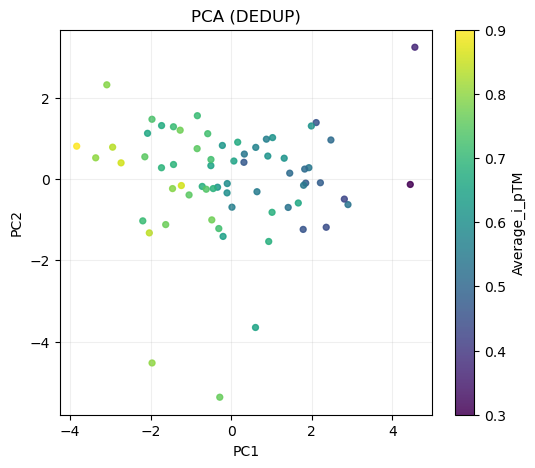

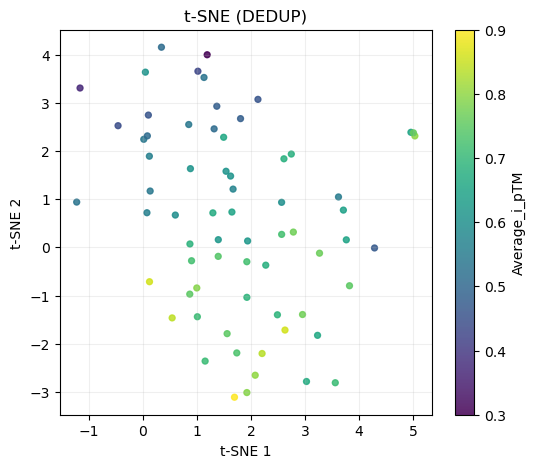

/opt/anaconda3/envs/bioinf/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Applied UMAP/sklearn compatibility shim (ensure_all_finite -> force_all_finite)


/opt/anaconda3/envs/bioinf/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


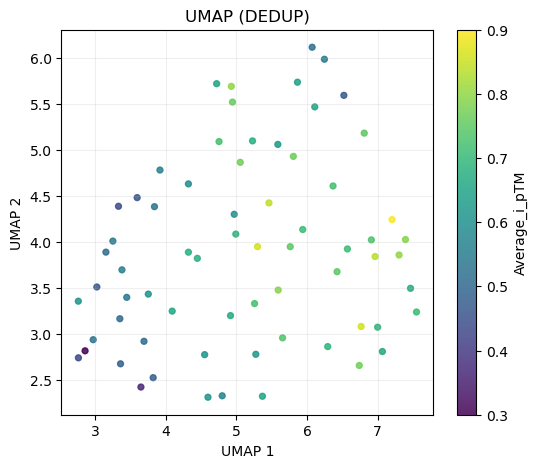

In [9]:
# ==============================
# Cell 10: Task 4 — embeddings (PCA / t-SNE / UMAP)
# ==============================
# (This cell can be run standalone; it re-imports the essentials.)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def select_embedding_df():
    if EMBED_ON.lower() == 'raw':
        return df_scored.copy(), 'RAW'
    return df_dedup.copy(), 'DEDUP'


def select_numeric_features(df_in: pd.DataFrame) -> list[str]:
    # Prefer Average_* metrics; exclude obviously non-feature columns
    exclude = {DUP_KEY, 'Design', 'Sequence', 'InterfaceResidues', 'InterfaceAAs', 'Notes', 'TargetSettings', 'Filters', 'AdvancedSettings', 'Protocol', 'source_file', 'source_name'}

    # Manual override: use exactly the user-provided columns (that exist and are numeric)
    if 'EMBED_FEATURE_COLS' in globals() and EMBED_FEATURE_COLS is not None:
        chosen = []
        missing = []
        non_numeric = []
        for c in EMBED_FEATURE_COLS:
            if c not in df_in.columns:
                missing.append(c)
                continue
            if not pd.api.types.is_numeric_dtype(df_in[c]):
                # try coercion (safe)
                coerced = pd.to_numeric(df_in[c], errors='coerce')
                if coerced.notna().any():
                    df_in[c] = coerced
                else:
                    non_numeric.append(c)
                    continue
            chosen.append(c)
        if missing:
            print('Embedding: missing requested feature columns:', missing)
        if non_numeric:
            print('Embedding: requested feature columns not usable as numeric:', non_numeric)
        if len(chosen) < 2:
            raise ValueError(f'EMBED_FEATURE_COLS left <2 usable numeric columns: {chosen}')
        return chosen

    # Auto selection
    cols = []
    for c in df_in.columns:
        if c in exclude:
            continue
        if c.startswith('Average_') and pd.api.types.is_numeric_dtype(df_in[c]):
            cols.append(c)
    # If almost nothing selected, fall back to all numeric columns
    if len(cols) < 3:
        cols = [c for c in df_in.columns if pd.api.types.is_numeric_dtype(df_in[c]) and c not in exclude]
    return cols


embed_df, embed_label = select_embedding_df()
feature_cols = select_numeric_features(embed_df)
print(f'Embedding on: {embed_label} | rows={len(embed_df)} | features={len(feature_cols)}')
print('Feature columns used:', feature_cols)

X = embed_df[feature_cols].to_numpy(dtype=float, copy=True)

# Impute missing, then standardize
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()
X_imp = imputer.fit_transform(X)
X_scaled = scaler.fit_transform(X_imp)

def _get_color_values(df_in: pd.DataFrame, color_col: str):
    if color_col is None or color_col not in df_in.columns:
        return None
    vals = df_in[color_col]
    # If numeric: return numeric; if not: return categorical codes
    if pd.api.types.is_numeric_dtype(vals):
        return vals.to_numpy()
    # categorical
    codes, _uniques = pd.factorize(vals.astype('string'))
    return codes

cvals = _get_color_values(embed_df, COLOR_COL)

# PCA
pca = PCA(n_components=N_COMPONENTS, random_state=RANDOM_STATE)
Z_pca = pca.fit_transform(X_scaled)
print('PCA explained variance ratio:', pca.explained_variance_ratio_)

plt.figure(figsize=(6, 5))
sc = plt.scatter(Z_pca[:, 0], Z_pca[:, 1], c=cvals if cvals is not None else None, s=18, cmap='viridis', alpha=0.85)
if cvals is not None:
    plt.colorbar(sc, label=COLOR_COL)
plt.title(f'PCA ({embed_label})')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True, alpha=0.2)
plt.show()

# t-SNE (can be slow for large N)
tsne = TSNE(n_components=2, random_state=RANDOM_STATE, init='pca', learning_rate='auto')
Z_tsne = tsne.fit_transform(X_scaled)
plt.figure(figsize=(6, 5))
sc = plt.scatter(Z_tsne[:, 0], Z_tsne[:, 1], c=cvals if cvals is not None else None, s=18, cmap='viridis', alpha=0.85)
if cvals is not None:
    plt.colorbar(sc, label=COLOR_COL)
plt.title(f't-SNE ({embed_label})')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.grid(True, alpha=0.2)
plt.show()

# UMAP (optional)
if RUN_UMAP:
    try:
        import inspect
        import sklearn.utils.validation as _skval
        import umap
        import umap.umap_ as _umap_mod

        # Compatibility shim: some umap-learn versions call sklearn.check_array(..., ensure_all_finite=...)
        # but older scikit-learn uses force_all_finite instead. If we detect that mismatch, patch the
        # check_array reference inside umap's module.
        sig = inspect.signature(_skval.check_array)
        if 'ensure_all_finite' not in sig.parameters and 'force_all_finite' in sig.parameters:
            _orig_check_array = _skval.check_array
            def _check_array_compat(*args, ensure_all_finite=True, **kwargs):
                kwargs['force_all_finite'] = ensure_all_finite
                return _orig_check_array(*args, **kwargs)
            _umap_mod.check_array = _check_array_compat
            print('Applied UMAP/sklearn compatibility shim (ensure_all_finite -> force_all_finite)')

        reducer = umap.UMAP(n_components=2, random_state=RANDOM_STATE)
        Z_umap = reducer.fit_transform(X_scaled)
        plt.figure(figsize=(6, 5))
        sc = plt.scatter(Z_umap[:, 0], Z_umap[:, 1], c=cvals if cvals is not None else None, s=18, cmap='viridis', alpha=0.85)
        if cvals is not None:
            plt.colorbar(sc, label=COLOR_COL)
        plt.title(f'UMAP ({embed_label})')
        plt.xlabel('UMAP 1')
        plt.ylabel('UMAP 2')
        plt.grid(True, alpha=0.2)
        plt.show()
    except TypeError as exc:
        msg = str(exc)
        if 'ensure_all_finite' in msg:
            raise RuntimeError(
                "UMAP failed due to a scikit-learn/umap-learn version mismatch (ensure_all_finite). "
                "Fix by upgrading scikit-learn (e.g. `conda install -c conda-forge scikit-learn>=1.2`) "
                "or downgrading umap-learn. The PCA and t-SNE plots above still work."
            ) from exc
        raise
    except ImportError as exc:
        print('UMAP not available. Install with: pip install umap-learn')

kNN/clustering space: umap | shape=(67, 2)
Cluster counts:


cluster
0    19
1    15
2    16
3    17
Name: count, dtype: int64

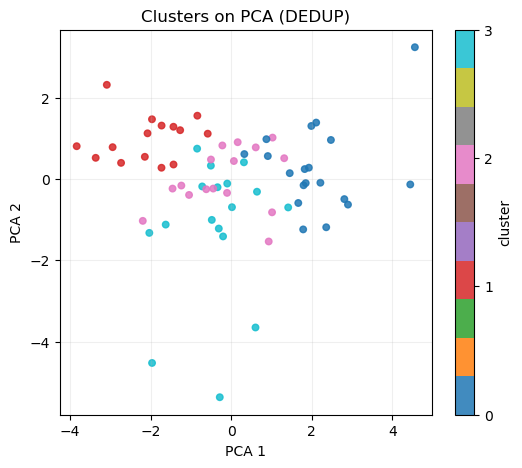

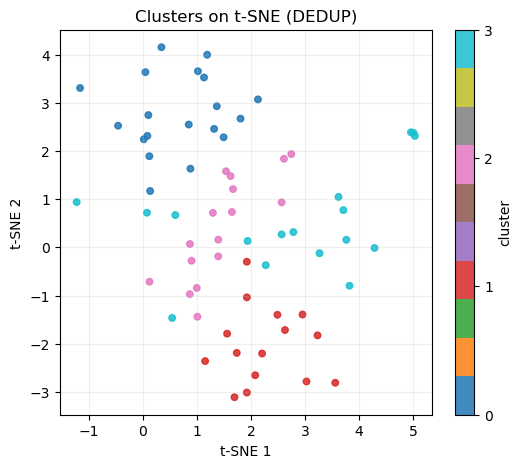

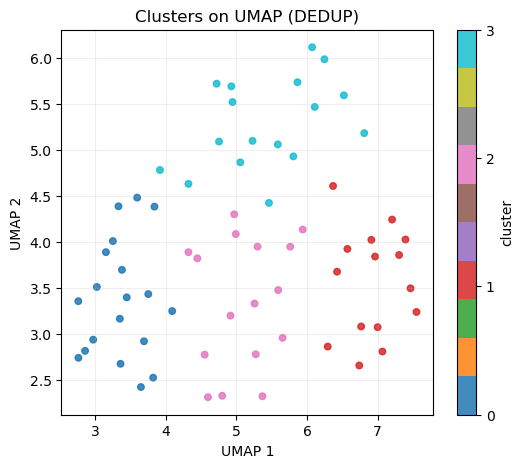


Top sequences per cluster:

Cluster 0 | n=19


,Sequence,Design,Average_pLDDT,Average_i_pTM,n_duplicates,source_name
16,CWKVVNDALVPC,c5_binder_sc66_l12_s799770_mpnn7,0.7800,0.510,1,_work_oo80wopo-bindcraft_BindCraftPeptide_data...
25,CWRNDWYTEC,c5_binder_sc66_l10_s867477,0.7700,0.540,1,_work_oo80wopo-bindcraft_BindCraftPeptide_data...
19,CFETEWLSIC,c5_binder_sc66_l10_s867477_mpnn4,0.7700,0.480,1,_work_oo80wopo-bindcraft_BindCraftPeptide_data...
33,CDVVLGSDGQWVC,c5_binder_sc69_l13_s17575_mpnn3,0.7600,0.510,1,_work_oo80wopo-bindcraft_BindCraftPeptide_data...
34,CRYNYYTDTVC,c5_binder_sc69_l11_s593413,0.7600,0.370,1,_work_oo80wopo-bindcraft_BindCraftPeptide_data...
47,CDVVLSSSGEWVC,c5_binder_sc69_l13_s17575_mpnn18,0.7500,0.540,1,_work_oo80wopo-bindcraft_BindCraftPeptide_data...
50,CWGSDGWFIPGPC,c5_binder_sc66_l13_s588478_mpnn17,0.7500,0.560,1,_work_oo80wopo-bindcraft_BindCraftPeptide_data...
40,CWAVVNDSILPC,c5_binder_sc66_l12_s799770_mpnn11,0.7500,0.480,1,_work_oo80wopo-bindcraft_BindCraftPeptide_data...
38,CWNPDGWFTPGPC,c5_binder_sc66_l13_s588478,0.7500,0.460,1,_work_oo80wopo-bindcraft_BindCraftPeptide_data...
42,CFQTEWMTVC,c5_binder_sc66_l10_s867477_mpnn18,0.7500,0.610,1,_work_oo80wopo-bindcraft_BindCraftPeptide_data...



Cluster 1 | n=15


,Sequence,Design,Average_pLDDT,Average_i_pTM,n_duplicates,source_name
0,CDYVLGDDGKWVC,c5_binder_sc69_l13_s17575_mpnn16,0.810000,0.900000,1,_work_oo80wopo-bindcraft_BindCraftPeptide_data...
1,CDWVLGSDSKWVC,c5_binder_sc69_l13_s17575_mpnn13,0.810000,0.660000,1,_work_oo80wopo-bindcraft_BindCraftPeptide_data...
2,CDYVYGPDSQWKC,c5_binder_sc69_l13_s17575_mpnn19,0.800000,0.800000,1,_work_oo80wopo-bindcraft_BindCraftPeptide_data...
3,CDWVYGSDSRWVC,c5_binder_sc69_l13_s17575_mpnn17,0.800000,0.790000,1,_work_oo80wopo-bindcraft_BindCraftPeptide_data...
6,CLQTDWLTIC,c5_binder_sc66_l10_s867477_mpnn16,0.790000,0.770000,1,_work_oo80wopo-bindcraft_BindCraftPeptide_data...
4,CLQTEWLTIC,c5_binder_sc66_l10_s867477_mpnn12,0.790000,0.730000,1,_work_oo80wopo-bindcraft_BindCraftPeptide_data...
5,CDWVWTADNRWKC,c5_binder_sc69_l13_s17575,0.790000,0.710000,1,_work_oo80wopo-bindcraft_BindCraftPeptide_data...
9,CFETDWLKIC,c5_binder_sc66_l10_s867477_mpnn17,0.783333,0.836667,3,_work_oo80wopo-bindcraft_BindCraftPeptide_data...
10,CDYVLGSDFQWVC,c5_binder_sc69_l13_s17575_mpnn7,0.780000,0.670000,1,_work_oo80wopo-bindcraft_BindCraftPeptide_data...
13,CDWVLGSDGKWVC,c5_binder_sc69_l13_s17575_mpnn12,0.780000,0.690000,1,_work_oo80wopo-bindcraft_BindCraftPeptide_data...



Cluster 2 | n=16


,Sequence,Design,Average_pLDDT,Average_i_pTM,n_duplicates,source_name
11,CDWVLGPDGQWKC,c5_binder_sc69_l13_s17575_mpnn8,0.7800,0.6500,1,_work_oo80wopo-bindcraft_BindCraftPeptide_data...
17,CFKTDWLEIC,c5_binder_sc66_l10_s867477_mpnn14,0.7800,0.6200,1,_work_oo80wopo-bindcraft_BindCraftPeptide_data...
24,CDVVLGSDGQWIC,c5_binder_sc69_l13_s17575_mpnn10,0.7700,0.7100,1,_work_oo80wopo-bindcraft_BindCraftPeptide_data...
23,CDWVYGSDGKWVC,c5_binder_sc69_l13_s17575_mpnn20,0.7700,0.7500,1,_work_oo80wopo-bindcraft_BindCraftPeptide_data...
37,CWAVVNDSLLPC,c5_binder_sc66_l12_s799770_mpnn2,0.7600,0.7400,1,_work_oo80wopo-bindcraft_BindCraftPeptide_data...
35,CWALVNDNLLPC,c5_binder_sc66_l12_s799770_mpnn16,0.7600,0.5700,1,_work_oo80wopo-bindcraft_BindCraftPeptide_data...
49,CDWVLGSDSQWVC,c5_binder_sc69_l13_s17575_mpnn2,0.7500,0.8600,1,_work_oo80wopo-bindcraft_BindCraftPeptide_data...
46,CWALVNDALLPC,c5_binder_sc66_l12_s799770_mpnn18,0.7500,0.7900,2,_work_oo80wopo-bindcraft_BindCraftPeptide_data...
41,CWKLVNDALLPC,c5_binder_sc66_l12_s799770_mpnn1,0.7500,0.6100,1,_work_oo80wopo-bindcraft_BindCraftPeptide_data...
43,CWAPDGWFVPGPC,c5_binder_sc66_l13_s588478_mpnn12,0.7500,0.6675,4,_work_oo80wopo-bindcraft_BindCraftPeptide_data...



Cluster 3 | n=17


,Sequence,Design,Average_pLDDT,Average_i_pTM,n_duplicates,source_name
7,CFKTEWLEIC,c5_binder_sc66_l10_s867477_mpnn20,0.7900,0.8000,1,_work_oo80wopo-bindcraft_BindCraftPeptide_data...
8,CFETEWLKIC,c5_binder_sc66_l10_s867477_mpnn10,0.7875,0.6775,4,_work_oo80wopo-bindcraft_BindCraftPeptide_data...
12,CWRVVNDVVLPC,c5_binder_sc66_l12_s799770_mpnn14,0.7800,0.6200,1,_work_oo80wopo-bindcraft_BindCraftPeptide_data...
15,CFKTEWLTIC,c5_binder_sc66_l10_s867477_mpnn1,0.7800,0.6500,1,_work_oo80wopo-bindcraft_BindCraftPeptide_data...
28,CLETDWLTVC,c5_binder_sc66_l10_s867477_mpnn11,0.7700,0.7500,1,_work_oo80wopo-bindcraft_BindCraftPeptide_data...
26,CWAVVNDALLPC,c5_binder_sc66_l12_s799770_mpnn20,0.7700,0.7600,1,_work_oo80wopo-bindcraft_BindCraftPeptide_data...
22,CDYVYGDDGQWKC,c5_binder_sc69_l13_s17575_mpnn6,0.7700,0.6500,1,_work_oo80wopo-bindcraft_BindCraftPeptide_data...
20,CFKTDWMTVC,c5_binder_sc66_l10_s867477_mpnn7,0.7700,0.4700,1,_work_oo80wopo-bindcraft_BindCraftPeptide_data...
30,CWGPDGWFVPGPC,c5_binder_sc66_l13_s588478_mpnn3,0.7650,0.5950,2,_work_oo80wopo-bindcraft_BindCraftPeptide_data...
31,CWAVVNDAVIPC,c5_binder_sc66_l12_s799770_mpnn8,0.7600,0.6400,1,_work_oo80wopo-bindcraft_BindCraftPeptide_data...


,metric,cluster_0_corr,cluster_0_mean,cluster_1_corr,cluster_1_mean,cluster_2_corr,cluster_2_mean,cluster_3_corr,cluster_3_mean
0,Average_pLDDT,-0.391191,0.748553,0.637671,0.786889,-0.281098,0.751094,0.069776,0.764265
1,Average_i_pTM,-0.706747,0.502368,0.464919,0.752444,0.179526,0.683906,0.110807,0.667500
2,Average_pTM,-0.689495,0.700921,0.645025,0.850889,0.161062,0.791250,-0.061504,0.765588
3,Average_pAE,0.744221,0.847105,-0.603536,0.527778,-0.146925,0.647031,-0.048778,0.671765
4,Average_Relaxed_Clashes,0.195646,0.052632,-0.066111,0.000000,-0.068945,0.000000,-0.071774,0.000000
5,Average_dG/dSASA,0.297174,-2.038553,0.200538,-2.094000,0.154873,-2.148281,-0.651668,-2.929412
6,Average_ShapeComplementarity,-0.207236,0.602105,-0.024158,0.624000,-0.056571,0.619688,0.293231,0.666176
7,Average_Hotspot_RMSD,0.182751,2.715526,0.265497,2.997556,-0.348148,1.453750,-0.102514,2.070441
8,Average_Target_RMSD,0.126769,12.967763,0.137643,13.069111,0.181376,13.194062,-0.440875,11.196324
9,Average_InterfaceHbondsPercentage,-0.088986,33.512500,0.242620,47.007556,-0.396144,20.639688,0.247900,46.402647



Top metric associations for cluster 0 (by |corr|):


,metric,cluster_0_corr,cluster_0_mean
3,Average_pAE,0.744221,0.847105
1,Average_i_pTM,-0.706747,0.502368
2,Average_pTM,-0.689495,0.700921
0,Average_pLDDT,-0.391191,0.748553
5,Average_dG/dSASA,0.297174,-2.038553
6,Average_ShapeComplementarity,-0.207236,0.602105
4,Average_Relaxed_Clashes,0.195646,0.052632
7,Average_Hotspot_RMSD,0.182751,2.715526
8,Average_Target_RMSD,0.126769,12.967763
9,Average_InterfaceHbondsPercentage,-0.088986,33.512500



Top metric associations for cluster 1 (by |corr|):


,metric,cluster_1_corr,cluster_1_mean
2,Average_pTM,0.645025,0.850889
0,Average_pLDDT,0.637671,0.786889
3,Average_pAE,-0.603536,0.527778
1,Average_i_pTM,0.464919,0.752444
7,Average_Hotspot_RMSD,0.265497,2.997556
9,Average_InterfaceHbondsPercentage,0.242620,47.007556
5,Average_dG/dSASA,0.200538,-2.094000
8,Average_Target_RMSD,0.137643,13.069111
4,Average_Relaxed_Clashes,-0.066111,0.000000
10,Average_InterfaceUnsatHbondsPercentage,0.049041,31.892667



Top metric associations for cluster 2 (by |corr|):


,metric,cluster_2_corr,cluster_2_mean
9,Average_InterfaceHbondsPercentage,-0.396144,20.639688
7,Average_Hotspot_RMSD,-0.348148,1.453750
0,Average_pLDDT,-0.281098,0.751094
8,Average_Target_RMSD,0.181376,13.194062
1,Average_i_pTM,0.179526,0.683906
2,Average_pTM,0.161062,0.791250
5,Average_dG/dSASA,0.154873,-2.148281
3,Average_pAE,-0.146925,0.647031
10,Average_InterfaceUnsatHbondsPercentage,0.082986,33.142031
4,Average_Relaxed_Clashes,-0.068945,0.000000



Top metric associations for cluster 3 (by |corr|):


,metric,cluster_3_corr,cluster_3_mean
5,Average_dG/dSASA,-0.651668,-2.929412
8,Average_Target_RMSD,-0.440875,11.196324
6,Average_ShapeComplementarity,0.293231,0.666176
9,Average_InterfaceHbondsPercentage,0.247900,46.402647
10,Average_InterfaceUnsatHbondsPercentage,-0.191410,22.671912
1,Average_i_pTM,0.110807,0.667500
7,Average_Hotspot_RMSD,-0.102514,2.070441
4,Average_Relaxed_Clashes,-0.071774,0.000000
0,Average_pLDDT,0.069776,0.764265
2,Average_pTM,-0.061504,0.765588


In [10]:
# ==============================
# Cell 11: kNN graph clustering + cluster reports
# ==============================
# This adds a kNN-based clustering step and then:
#  - plots clusters on PCA/t-SNE/UMAP coordinates (if available)
#  - prints sequences per cluster
#  - computes (point-biserial) correlations of each metric with each cluster membership

from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import AgglomerativeClustering, SpectralClustering

# --- user-tunable clustering settings ---
KNN_N_NEIGHBORS = 15          # size of kNN graph
N_CLUSTERS = 4                # desired number of clusters (tune!)
CLUSTER_METHOD = "spectral"   # 'spectral' (kNN affinity) or 'agglo' (kNN connectivity)
TOP_N_SEQS_PER_CLUSTER = 25   # how many sequences to print per cluster
METRIC_COLS_FOR_CORR = EMBED_FEATURE_COLS  # None => use numeric Average_* columns; or pass list of metric columns

# NEW: choose where kNN is computed
# - 'scaled'  : use X_scaled (original feature space, standardized)
# - 'pca'     : use Z_pca coordinates (requires Cell 10 to have run)
# - 'tsne'    : use Z_tsne coordinates (requires Cell 10 to have run)
# - 'umap'    : use Z_umap coordinates (requires Cell 10 to have run + RUN_UMAP=True)
KNN_SPACE = "umap"  # one of: 'scaled','pca','tsne','umap'

def _select_knn_matrix(knn_space: str) -> np.ndarray:
    s = knn_space.lower().strip()
    if s == "scaled":
        if "X_scaled" not in globals():
            raise RuntimeError("X_scaled not found. Run the embeddings cell (Cell 10) first.")
        return X_scaled
    if s == "pca":
        Z = globals().get("Z_pca", None)
        if Z is None:
            raise RuntimeError("Z_pca not found. Run the embeddings cell (Cell 10) first.")
        return Z
    if s == "tsne":
        Z = globals().get("Z_tsne", None)
        if Z is None:
            raise RuntimeError("Z_tsne not found. Run the embeddings cell (Cell 10) first.")
        return Z
    if s == "umap":
        Z = globals().get("Z_umap", None)
        if Z is None:
            raise RuntimeError("Z_umap not found. Run the embeddings cell (Cell 10) with RUN_UMAP=True first.")
        return Z
    raise ValueError("KNN_SPACE must be one of: 'scaled','pca','tsne','umap'")

X_knn = _select_knn_matrix(KNN_SPACE)
print(f"kNN/clustering space: {KNN_SPACE} | shape={getattr(X_knn, 'shape', None)}")

# Build a kNN graph in the selected space
A = kneighbors_graph(X_knn, n_neighbors=KNN_N_NEIGHBORS, mode="connectivity", include_self=False)

if CLUSTER_METHOD.lower() == "spectral":
    clustering = SpectralClustering(
        n_clusters=N_CLUSTERS,
        affinity="nearest_neighbors",
        n_neighbors=KNN_N_NEIGHBORS,
        random_state=RANDOM_STATE,
    )
    labels = clustering.fit_predict(X_knn)
elif CLUSTER_METHOD.lower() == "agglo":
    clustering = AgglomerativeClustering(
        n_clusters=N_CLUSTERS,
        linkage="ward",
        connectivity=A,
    )
    labels = clustering.fit_predict(X_knn)
else:
    raise ValueError("CLUSTER_METHOD must be 'spectral' or 'agglo'")

embed_df_with_clusters = embed_df.copy()
embed_df_with_clusters["cluster"] = labels
clusters = sorted(embed_df_with_clusters["cluster"].unique())
print("Cluster counts:")
display(embed_df_with_clusters["cluster"].value_counts().sort_index())

# ---- plot clusters on embedding coordinates ----
def _plot_clusters(Z: np.ndarray | None, name: str):
    if Z is None:
        return
    if not isinstance(Z, np.ndarray) or Z.ndim != 2 or Z.shape[1] < 2:
        print(f"Skipping {name}: unexpected shape")
        return
    n_clusters = len(np.unique(labels))
    cmap = "tab20" if n_clusters > 10 else "tab10"
    plt.figure(figsize=(6, 5))
    sc = plt.scatter(Z[:, 0], Z[:, 1], c=labels, s=22, cmap=cmap, alpha=0.85)
    cbar = plt.colorbar(sc, ticks=clusters)
    cbar.set_label("cluster")
    plt.title(f"Clusters on {name} ({embed_label})")
    plt.xlabel(f"{name} 1")
    plt.ylabel(f"{name} 2")
    plt.grid(True, alpha=0.2)
    plt.show()

Z_pca_plot = globals().get("Z_pca", None)
Z_tsne_plot = globals().get("Z_tsne", None)
Z_umap_plot = globals().get("Z_umap", None)
_plot_clusters(Z_pca_plot, "PCA")
_plot_clusters(Z_tsne_plot, "t-SNE")
_plot_clusters(Z_umap_plot, "UMAP")

# ---- print sequences per cluster (sorted by score) ----
if SCORE_COL in embed_df_with_clusters.columns:
    embed_df_with_clusters = embed_df_with_clusters.sort_values(by=SCORE_COL, ascending=False)

print("\nTop sequences per cluster:")
for c in clusters:
    sub = embed_df_with_clusters[embed_df_with_clusters["cluster"] == c]
    print(f"\nCluster {c} | n={len(sub)}")
    cols_to_show = [x for x in ["Sequence", "Design", SCORE_COL, COLOR_COL, "n_duplicates", "source_name"] if x in sub.columns]
    display(sub[cols_to_show].head(TOP_N_SEQS_PER_CLUSTER))

# ---- correlations: metric vs cluster membership (binary) ----
def _point_biserial_corr(x: np.ndarray, y_binary: np.ndarray) -> float:
    # Pearson correlation between numeric x and 0/1 membership vector
    mask = np.isfinite(x) & np.isfinite(y_binary)
    if mask.sum() < 3:
        return np.nan
    x2 = x[mask].astype(float)
    y2 = y_binary[mask].astype(float)
    if np.std(x2) == 0 or np.std(y2) == 0:
        return np.nan
    return float(np.corrcoef(x2, y2)[0, 1])

# Decide which metrics to test correlation for
if METRIC_COLS_FOR_CORR is None:
    metric_cols = [c for c in embed_df_with_clusters.columns if c.startswith("Average_") and pd.api.types.is_numeric_dtype(embed_df_with_clusters[c])]
    if len(metric_cols) < 3:
        metric_cols = [c for c in embed_df_with_clusters.columns if pd.api.types.is_numeric_dtype(embed_df_with_clusters[c])]
else:
    metric_cols = [c for c in METRIC_COLS_FOR_CORR if c in embed_df_with_clusters.columns]

corr_rows = []
for metric in metric_cols:
    x = pd.to_numeric(embed_df_with_clusters[metric], errors="coerce").to_numpy()
    row = {"metric": metric}
    for c in clusters:
        y = (embed_df_with_clusters["cluster"].to_numpy() == c).astype(float)
        row[f"cluster_{c}_corr"] = _point_biserial_corr(x, y)
        row[f"cluster_{c}_mean"] = float(np.nanmean(x[embed_df_with_clusters["cluster"].to_numpy() == c])) if np.isfinite(x).any() else np.nan
    corr_rows.append(row)

df_cluster_corr = pd.DataFrame(corr_rows)
display(df_cluster_corr.head(10))

# Show, for each cluster, the top metrics most associated with membership (by abs correlation)
TOP_METRICS_PER_CLUSTER = 10
for c in clusters:
    corr_col = f"cluster_{c}_corr"
    mean_col = f"cluster_{c}_mean"
    if corr_col not in df_cluster_corr.columns:
        continue
    tmp = df_cluster_corr[["metric", corr_col, mean_col]].copy()
    tmp["abs_corr"] = tmp[corr_col].abs()
    tmp = tmp.sort_values(by="abs_corr", ascending=False).head(TOP_METRICS_PER_CLUSTER)
    print(f"\nTop metric associations for cluster {c} (by |corr|):")
    display(tmp.drop(columns=["abs_corr"]))

In [11]:
# ==============================
# Cell 11: Optional — save outputs
# ==============================
OUT_DIR = CSV_DIR / '_aggregated'
OUT_DIR.mkdir(parents=True, exist_ok=True)

out_raw = OUT_DIR / 'merged_raw.csv'
out_sorted = OUT_DIR / 'merged_scored_sorted.csv'
out_dedup = OUT_DIR / 'merged_dedup_by_sequence.csv'

df_raw.to_csv(out_raw, index=False)
df_scored.to_csv(out_sorted, index=False)
df_dedup.to_csv(out_dedup, index=False)

print('Wrote:')
print(' -', out_raw)
print(' -', out_sorted)
print(' -', out_dedup)

Wrote:
 - example/c5/out_csv/_aggregated/merged_raw.csv
 - example/c5/out_csv/_aggregated/merged_scored_sorted.csv
 - example/c5/out_csv/_aggregated/merged_dedup_by_sequence.csv
